## Predict r2 from grad loading? 
are own gradient values better than Margulies?
`pyGAM` - general additive modeling 
use splines or tensor products to model a specific location in gradient space to have high variance explained by nPRF model
specifically, can own gradient maps better predict than Margulies (based on macroatomy)

1. Loop over subs to get pseudoR2 for own compared to Marg GMs --> plot distribution
    * normal splines `s()`
    * tensor product `te()`
2. For ind. subjects: Visualize model fit via predictions 
    * normal splines `s()`
    * tensor product `te()`

#### Open Questions /  dont fully understand pyGAM yet though 
* only in NPC mask??
* lambdas- smoothing param, reduces effective DoF
* n_splines
* which param is best for measure model performance? pseudo-R2 is usually better for own, but logLikelihood or AIC is worse for own comp. to Margulies gradients

In [ ]:
import numpy as np
import nibabel as nib
from nilearn import datasets
import os.path as op
import os
import pandas as pd

import nilearn.plotting as nplt
import matplotlib.pyplot as plt
import seaborn as sns

bids_folder = '/mnt_03/ds-dnumrisk' 
key = 'encoding_model.denoise'
plot_folder = op.join(bids_folder,'plots_and_ims')
from os import listdir
subList = [f[4:6] for f in listdir(op.join(bids_folder)) if f[0:4] == 'sub-' and len(f)==6]
subList.remove('03')
decode = pd.read_csv(op.join(bids_folder,'derivatives/phenotype/decoding_r.csv')).set_index('subject')
subList_fil = [sub for sub in subList if decode.loc[int(sub)]['r'] > 0.1]

par = 'r2'
spec = 'g-aligned'

In [ ]:
from utils import get_margGMs12_fsav5
from utils import get_nPRFs_params
from numrisk.fmri_analysis.gradients.utils import get_basic_mask
from pygam import LinearGAM, s

grad_Marg = get_margGMs12_fsav5(bids_folder)

from numrisk.fmri_analysis.gradients.utils import get_basic_mask
mask_basic, _ = get_basic_mask()

# get general NPC mask
surf_mask_L = op.join(bids_folder, 'derivatives/surface_masks', 'desc-NPC_L_space-fsaverage5_hemi-lh.label.gii')
surf_mask_L = nib.load(surf_mask_L).agg_data()
surf_mask_R = op.join(bids_folder, 'derivatives/surface_masks', 'desc-NPC_R_space-fsaverage5_hemi-rh.label.gii')
surf_mask_R = nib.load(surf_mask_R).agg_data()
npc_mask = np.bool_(np.concatenate((surf_mask_L, surf_mask_R)))

from utils import get_nPRFs_params
from pygam import LinearGAM, s, te

In [ ]:
# specifications

n_splines = 5
mask_name =  'NPC' #  'basic' # 

In [ ]:
# Normal spline

#  mask = mask_basic.copy() if mask_name == 'basic' else  npc_mask.copy()
r2_s_ownGMs = []
coef_s_ownGMs = []
r2_s_margGMs = []
coef_s_margGMs = []
for sub in subList_fil:
    nprf_r2 = get_nPRFs_params(sub=sub,bids_folder=bids_folder)
    fn = op.join(bids_folder,'derivatives/gradients',f'sub-{sub}',f'sub-{sub}_{spec}_space-fsaverag5_n10.npy') #space-{space}_n{n_comp}.npy')
    grad_sub = np.load(fn)
 
    grad = grad_sub
    mask = mask_basic.copy() if mask_name == 'basic' else  npc_mask.copy()
    if np.any((np.isnan(grad[:2,mask]))):
        mask[np.isnan(grad[0,])] = False
    X = grad[:2,mask].T  # Predictors grad1 & grad2 
    y = nprf_r2[mask] 
    gam = LinearGAM(s(0, n_splines=n_splines) + s(1, n_splines=n_splines))  # s(0) -> smooth term for x1, s(1) -> smooth term for x2
    gam.fit(X, y)
    r2_s_ownGMs.append(gam.statistics_['pseudo_r2']['explained_deviance'])
    coef_s_ownGMs.append(gam.coef_)

    grad = grad_Marg
    mask = mask_basic.copy() if mask_name == 'basic' else  npc_mask.copy()
    X = grad[:2,mask].T  # Predictors grad1 & grad2 
    y = nprf_r2[mask] 
    gam = LinearGAM(s(0, n_splines=n_splines) + s(1, n_splines=n_splines))  # s(0) -> smooth term for x1, s(1) -> smooth term for x2
    gam.fit(X, y)
    r2_s_margGMs.append(gam.statistics_['pseudo_r2']['explained_deviance'])
    coef_s_margGMs.append(gam.coef_)


#df = pd.DataFrame(data=np.array([[int(sub) for sub in subList_fil],r2_s_ownGMs, r2_s_margGMs]).T, columns=['subject','r2_s_ownGMs','r2_s_margGMs' ])

0.030029884175606255


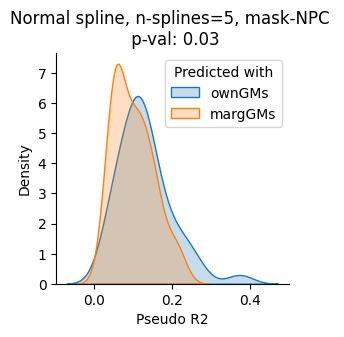

In [81]:
fig = plt.figure(figsize=(3,3))
sns.kdeplot(r2_s_ownGMs,fill=True, label='ownGMs')
sns.kdeplot(r2_s_margGMs,fill=True, label='margGMs')
plt.legend(loc='upper right',title='Predicted with' )
plt.xlabel('Pseudo R2')

from scipy.stats import ttest_ind
t_stat, p_value = ttest_ind(r2_s_ownGMs, r2_s_margGMs)
plt.title(f'Normal spline, n-splines={n_splines}, mask-{mask_name} \n p-val: {np.round(p_value,3)}')
sns.despine()
print(p_value)

0.00882134698711275 - basic


In [ ]:
# look which subs have good r2 
df = pd.DataFrame(data=np.array([[int(sub) for sub in subList_fil],r2_s_ownGMs, r2_s_margGMs]).T, columns=['subject','r2_s_ownGMs','r2_s_margGMs' ])
df

,subject,r2_s_ownGMs,r2_s_margGMs
0,15.0,0.100230,0.095591
1,52.0,0.090357,0.087018
2,8.0,0.215534,0.134399
3,57.0,0.108224,0.053548
4,50.0,0.071161,0.095547
5,2.0,0.025551,0.023777
6,22.0,0.127317,0.092746
7,19.0,0.072265,0.074602
8,18.0,0.052081,0.051256
9,31.0,0.129094,0.081634


In [83]:
# Tensor product formula

#mask = mask_basic # npc_mask
r2_te_ownGMs = []
#coef_te_ownGMs = []
r2_te_margGMs = []
#coef_s_margGMs = []
for sub in subList_fil:
    nprf_r2 = get_nPRFs_params(sub=sub,bids_folder=bids_folder)
    fn = op.join(bids_folder,'derivatives/gradients',f'sub-{sub}',f'sub-{sub}_{spec}_space-fsaverag5_n10.npy') #space-{space}_n{n_comp}.npy')
    grad_sub = np.load(fn)
 
    grad = grad_sub
    mask = mask_basic.copy() if mask_name == 'basic' else  npc_mask.copy()
    if np.any((np.isnan(grad[:2,mask]))):
        mask[np.isnan(grad[0,])] = False
    X = grad[:2,mask].T  # Predictors grad1 & grad2 
    y = nprf_r2[mask] 
    gam = LinearGAM(te(0, 1, n_splines=n_splines))     
    gam.fit(X, y)
    r2_te_ownGMs.append(gam.statistics_['pseudo_r2']['explained_deviance'])
    #coef_s_ownGMs.append(gam.coef_)

    grad = grad_Marg
    mask = mask_basic.copy() if mask_name == 'basic' else  npc_mask.copy()
    X = grad[:2,mask].T  # Predictors grad1 & grad2 
    y = nprf_r2[mask] 
    gam = LinearGAM(te(0, 1, n_splines=n_splines))     
    gam.fit(X, y)
    r2_te_margGMs.append(gam.statistics_['pseudo_r2']['explained_deviance'])
    #coef_s_margGMs.append(gam.coef_)


0.016167425379312563


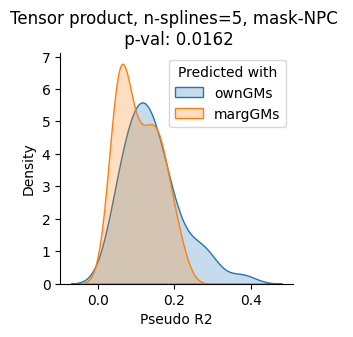

In [84]:
fig = plt.figure(figsize=(3,3))
sns.kdeplot(r2_te_ownGMs,fill=True, label='ownGMs')
sns.kdeplot(r2_te_margGMs,fill=True, label='margGMs')
plt.legend(loc='upper right',title='Predicted with' )
plt.xlabel('Pseudo R2')
from scipy.stats import ttest_ind
t_stat, p_value = ttest_ind(r2_te_ownGMs, r2_te_margGMs)
plt.title(f'Tensor product, n-splines={n_splines}, mask-{mask_name} \n p-val: {np.round(p_value,4)}')
sns.despine()
print(p_value)

In [8]:
from numrisk.fmri_analysis.gradients.utils import get_basic_mask
import matplotlib.pyplot as plt

mask_basic, _ = get_basic_mask()

from pygam import LinearGAM, s


## Normal splines for ind. subjects - visualize 

look at df table for which subs have good r2
e.g. 12, 60, 45, (in NPC regions also!)

Pseudo R-Squared: 0.1075555972940132
Pseudo R-Squared: 0.23719983456598182


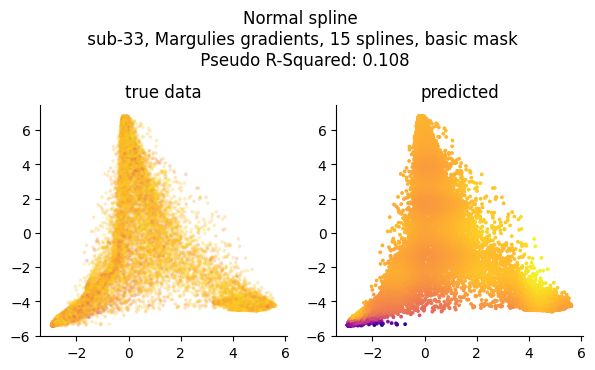

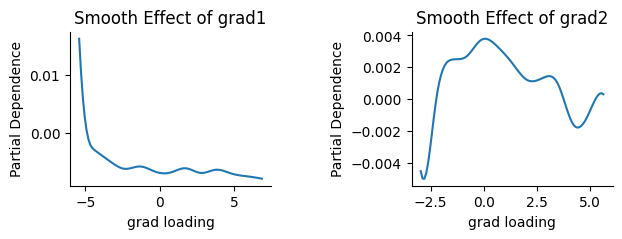

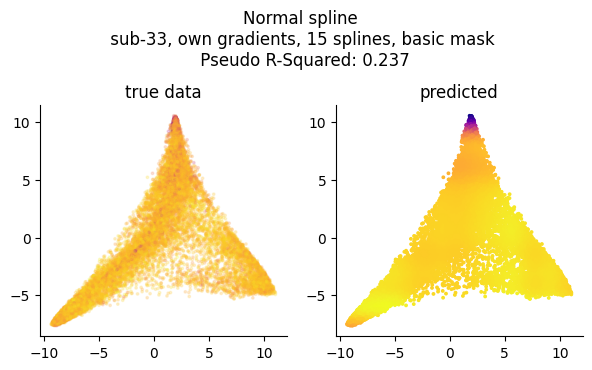

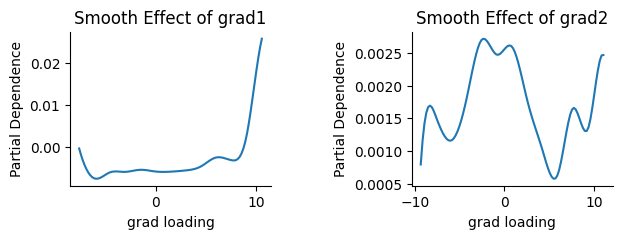

In [62]:
sub = '33'
n_splines = 15
mask_name =  'basic' # 'NPC' # 

for grad_names in  ['Margulies', 'own']: #


    mask = mask_basic if mask_name == 'basic' else  npc_mask
    # get data
    nprf_r2 = get_nPRFs_params(sub=sub,bids_folder=bids_folder)
    fn = op.join(bids_folder,'derivatives/gradients',f'sub-{sub}',f'sub-{sub}_g-aligned_space-fsaverag5_n10.npy') #space-{space}_n{n_comp}.npy')
    grad_sub = np.load(fn) # grad[1,:],grad[0,:]
    grad = grad_sub if grad_names == 'own' else grad_Marg
    if np.any((np.isnan(grad[:2,mask]))):
        mask[np.isnan(grad[0,])] = False
    
    # Define the GAM model with smooth terms for x1 and x2
    gam = LinearGAM(s(0, n_splines=n_splines) + s(1, n_splines=n_splines))  # s(0) -> smooth term for x1, s(1) -> smooth term for x2
    X = grad[:2,mask].T  # Predictors grad1 & grad2 
    y = nprf_r2[mask] 
    gam.fit(X, y)

    r2 = gam.statistics_['pseudo_r2']['explained_deviance']
    print(f'Pseudo R-Squared: {r2}')
    #print(gam.summary()) # Display the summary of the model

    predictions = gam.predict(X)

    fig, ax = plt.subplots(1,2,figsize=(7,3))
    cmap = 'plasma_r'
    ax[0].scatter(X[:,1],X[:,0], c=y, s=3,cmap=cmap,alpha=0.2)#.set_title('true data')
    ax[1].scatter(X[:,1],X[:,0], c=predictions, s=3,cmap=cmap)#.set_title('predicted')
    ax[0].set_title('true data')
    ax[1].set_title('predicted')
    fig.suptitle(f'Normal spline \n sub-{sub}, {grad_names} gradients, {n_splines} splines, {mask_name} mask \n Pseudo R-Squared: {np.round(r2,3)}', y=1.2)

    sns.despine()


    # Plot the smooth effect for x1
    fig, ax = plt.subplots(1,2,figsize=(7,2))

    for i,grad_name in enumerate(['grad1','grad2']):
        X_grid = gam.generate_X_grid(term=i)  # Create grid for term 0 (x1)
        partial_dep = gam.partial_dependence(term=i, X=X_grid)
        ax[i].plot(X_grid[:, i], partial_dep, label="Partial Dependence")
        ax[i].set(title=f'Smooth Effect of {grad_name}', xlabel='grad loading', ylabel = 'Partial Dependence')
        sns.despine()
    fig.subplots_adjust(wspace=0.7)

## Tensor produt for ind. subjects - visualize 

Pseudo R-Squared: 0.11995047735433317
Pseudo R-Squared: 0.30380630909403106


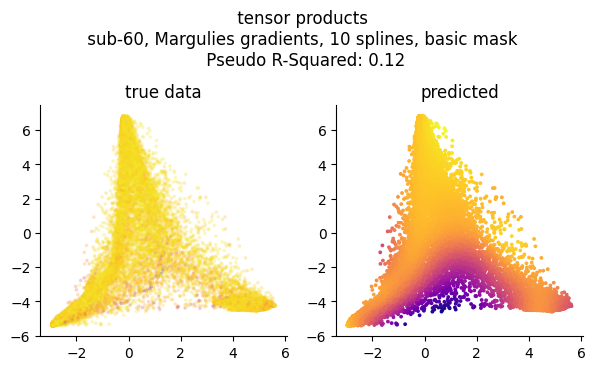

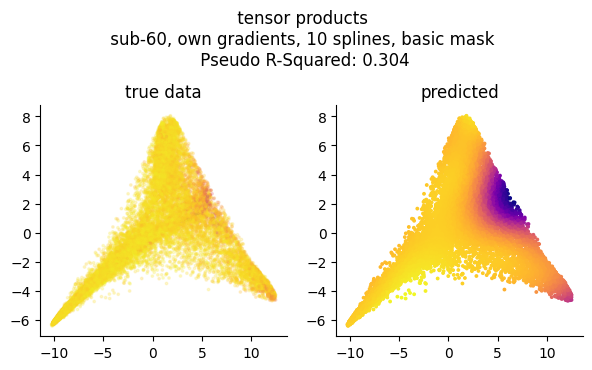

In [61]:
#  tensor products

sub = '60'
n_splines = 10
mask_name =  'basic' # 'NPC' # 

from pygam import te
for grad_names in  ['Margulies', 'own']: #


    mask = mask_basic if mask_name == 'basic' else  npc_mask
    # get data
    nprf_r2 = get_nPRFs_params(sub=sub,bids_folder=bids_folder)
    fn = op.join(bids_folder,'derivatives/gradients',f'sub-{sub}',f'sub-{sub}_g-aligned_space-fsaverag5_n10.npy') #space-{space}_n{n_comp}.npy')
    grad_sub = np.load(fn) # grad[1,:],grad[0,:]
    grad = grad_sub if grad_names == 'own' else grad_Marg
    if np.any((np.isnan(grad[:2,mask]))):
        mask[np.isnan(grad[0,])] = False
    
    # Define the GAM model with smooth terms for x1 and x2
    gam = LinearGAM(te(0, 1, n_splines=n_splines))  # s(0) -> smooth term for x1, s(1) -> smooth term for x2
    X = grad[:2,mask].T  # Predictors grad1 & grad2 
    y = nprf_r2[mask] 
    gam.fit(X, y)

    r2 = gam.statistics_['pseudo_r2']['explained_deviance']
    print(f'Pseudo R-Squared: {r2}')
    #print(gam.summary()) # Display the summary of the model

    predictions = gam.predict(X)

    fig, ax = plt.subplots(1,2,figsize=(7,3))
    cmap = 'plasma_r'
    ax[0].scatter(X[:,1],X[:,0], c=y, s=3,cmap=cmap,alpha=0.2)#.set_title('true data')
    ax[1].scatter(X[:,1],X[:,0], c=predictions, s=3,cmap=cmap)#.set_title('predicted')
    ax[0].set_title('true data')
    ax[1].set_title('predicted')
    fig.suptitle(f' tensor products \n sub-{sub}, {grad_names} gradients, {n_splines} splines, {mask_name} mask \n Pseudo R-Squared: {np.round(r2,3)}', y=1.2)
    sns.despine()



In [48]:
#gam.summary()

[Text(0.5, 0, 'grad-1'), Text(0.5, 0.5, 'grad-2')]

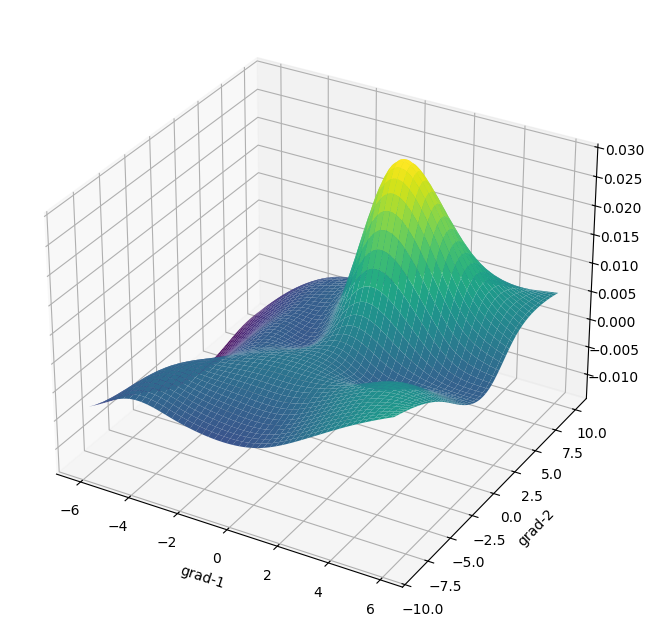

In [11]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

plt.ion()
plt.rcParams['figure.figsize'] = (12, 8)


XX = gam.generate_X_grid(term=0, meshgrid=True)
Z = gam.partial_dependence(term=0, X=XX, meshgrid=True)

ax = plt.axes(projection='3d')
ax.plot_surface(XX[0], XX[1], Z, cmap='viridis')
ax.set(xlabel='grad-1', ylabel='grad-2')

In [39]:
len(gam.coef_)

226

LogLike
-71765944.0743 own
-61603300.935 Marg

AIC
123206637.6631 Marg
143531922.3072 own

## Addtional



Text(0.5, 1.05, 'sub-12')

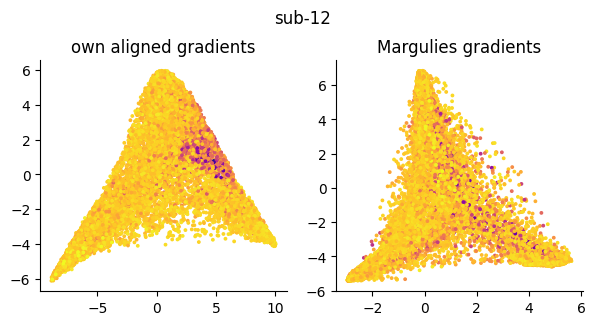

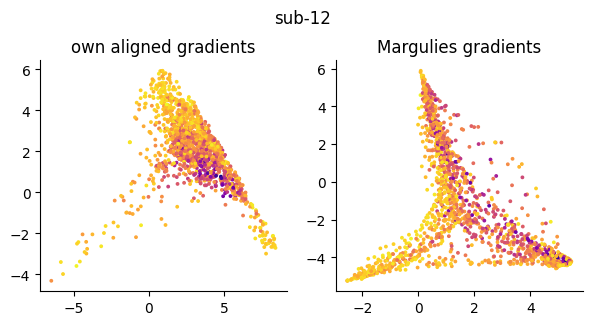

In [54]:
sub = '12'

# get data
nprf_r2 = get_nPRFs_params(sub=sub,bids_folder=bids_folder)
fn = op.join(bids_folder,'derivatives/gradients',f'sub-{sub}',f'sub-{sub}_g-aligned_space-fsaverag5_n10.npy') #space-{space}_n{n_comp}.npy')
grad_sub = np.load(fn) # grad[1,:],grad[0,:]

# plot 
fig, ax = plt.subplots(1,2,figsize=(7,3))
cmap = 'plasma_r'
ax[0].scatter(grad_sub[1,:],grad_sub[0,:], c=nprf_r2, s=3,cmap=cmap) # x,y -- ylabel = grad2 ; xlabel = grad1
ax[1].scatter(grad_Marg[1,:],grad_Marg[0,:], c=nprf_r2, s=3,cmap=cmap) # x,y -- ylabel = grad2 ; xlabel = grad1
ax[0].set(title='own aligned gradients')
ax[1].set(title='Margulies gradients')
sns.despine()
fig.suptitle(f'sub-{sub}',y=1.05)

fig, ax = plt.subplots(1,2,figsize=(7,3))
cmap = 'plasma_r'
ax[0].scatter(grad_sub[1,npc_mask],grad_sub[0,npc_mask], c=nprf_r2[npc_mask], s=3,cmap=cmap) # x,y -- ylabel = grad2 ; xlabel = grad1
ax[1].scatter(grad_Marg[1,npc_mask],grad_Marg[0,npc_mask], c=nprf_r2[npc_mask], s=3,cmap=cmap) # x,y -- ylabel = grad2 ; xlabel = grad1
ax[0].set(title='own aligned gradients')
ax[1].set(title='Margulies gradients')
sns.despine()

fig.suptitle(f'sub-{sub}',y=1.05)